In [ ]:
# -----------------------------------------------------
# Citing Relevant Assets
# This project utilizes several open-source libraries and assets:
# 1. Pre-trained models are sourced from Huggingface and Stable Baselines3, 
#    specifically the Proximal Policy Optimization (PPO) models: "sb3/ppo-CartPole-v1" and "sb3/ppo-LunarLander-v2"
#    and "sb3/ppo-LunarLander-v2" (https://huggingface.co/sb3).
# 2. The PySR library is employed for symbolic regression: 
#    Cranmer, Miles, et al., "PySR: Fast & Scalable Symbolic Regression in Python" (2023), 
#    available at https://github.com/MilesCranmer/PySR.
# 3. For Reinforcement Learning environments, the Gym library from OpenAI is used: 
#    Brockman, G., et al., "OpenAI Gym", available at https://github.com/openai/gym.
# 4. The project is conducted in the context of the lecture Advanced Topics in Reinforcement Learning 
#    at Gottfried Wilhelm Leibniz Universität Hannover, under Prof. Dr. Marius Lindauer and Theresa Eimer (2024).
# 
# Ensure to properly cite these resources in any external use or publication derived from this work.
# -----------------------------------------------------

In [1]:
!pip install git+https://github.com/google-research/rliable
!pip install seaborn==0.11.2
!pip install pysr==0.19.4

  Cloning https://github.com/google-research/rliable to /tmp/pip-req-build-z5khfoaz
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/rliable /tmp/pip-req-build-z5khfoaz
  Resolved https://github.com/google-research/rliable to commit 3ccd9f4dea577a04d3d2b557f259aac08badbd81
  Preparing metadata (setup.py) ... done


Mounted at /content/drive
Available files: ['pysr_models_r250_s2.pkl', 'episode_rewards_r250_s1.pkl', 'pysr_models_r250_s1.pkl', 'pysr_models_r250_s0.pkl', 'episode_rewards_r250_s0.pkl', 'episode_rewards_r250_s2.pkl', 'pysr_models_r250_s42.pkl', 'episode_rewards_r250_s42.pkl', 'pysr_models_r500_s2.pkl', 'pysr_models_r500_s0.pkl', 'episode_rewards_r500_s0.pkl', 'episode_rewards_r500_s2.pkl', 'pysr_models_r500_s42.pkl', 'episode_rewards_r500_s42.pkl', 'pysr_models_r1000_s2.pkl', 'pysr_models_r1000_s0.pkl', 'episode_rewards_r1000_s0.pkl', 'pysr_models_r1000_s42.pkl', 'episode_rewards_r1000_s42.pkl', 'pysr_models_r250_s43.pkl', 'episode_rewards_r250_s43.pkl', 'pysr_models_r0_s0.pkl', 'episode_rewards_r0_s0.pkl', 'pysr_models_r0_s42.pkl', 'episode_rewards_r0_s42.pkl', 'pysr_models_r500_s43.pkl', 'episode_rewards_r500_s43.pkl', 'episode_rewards_r1000_s2.pkl', 'pysr_models_r0_s43.pkl', 'episode_rewards_r0_s43.pkl', 'pysr_models_r1000_s1.pkl', 'episode_rewards_r1000_s1.pkl', 'pysr_models_r1000

<ipython-input-3-b73cc2474314>:95: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(highlighted_point[1], results_for_seeds_[highlighted_point[0]][0][highlighted_point[1]][0], 'ro', color=color_palette[highlighted_point[0]])


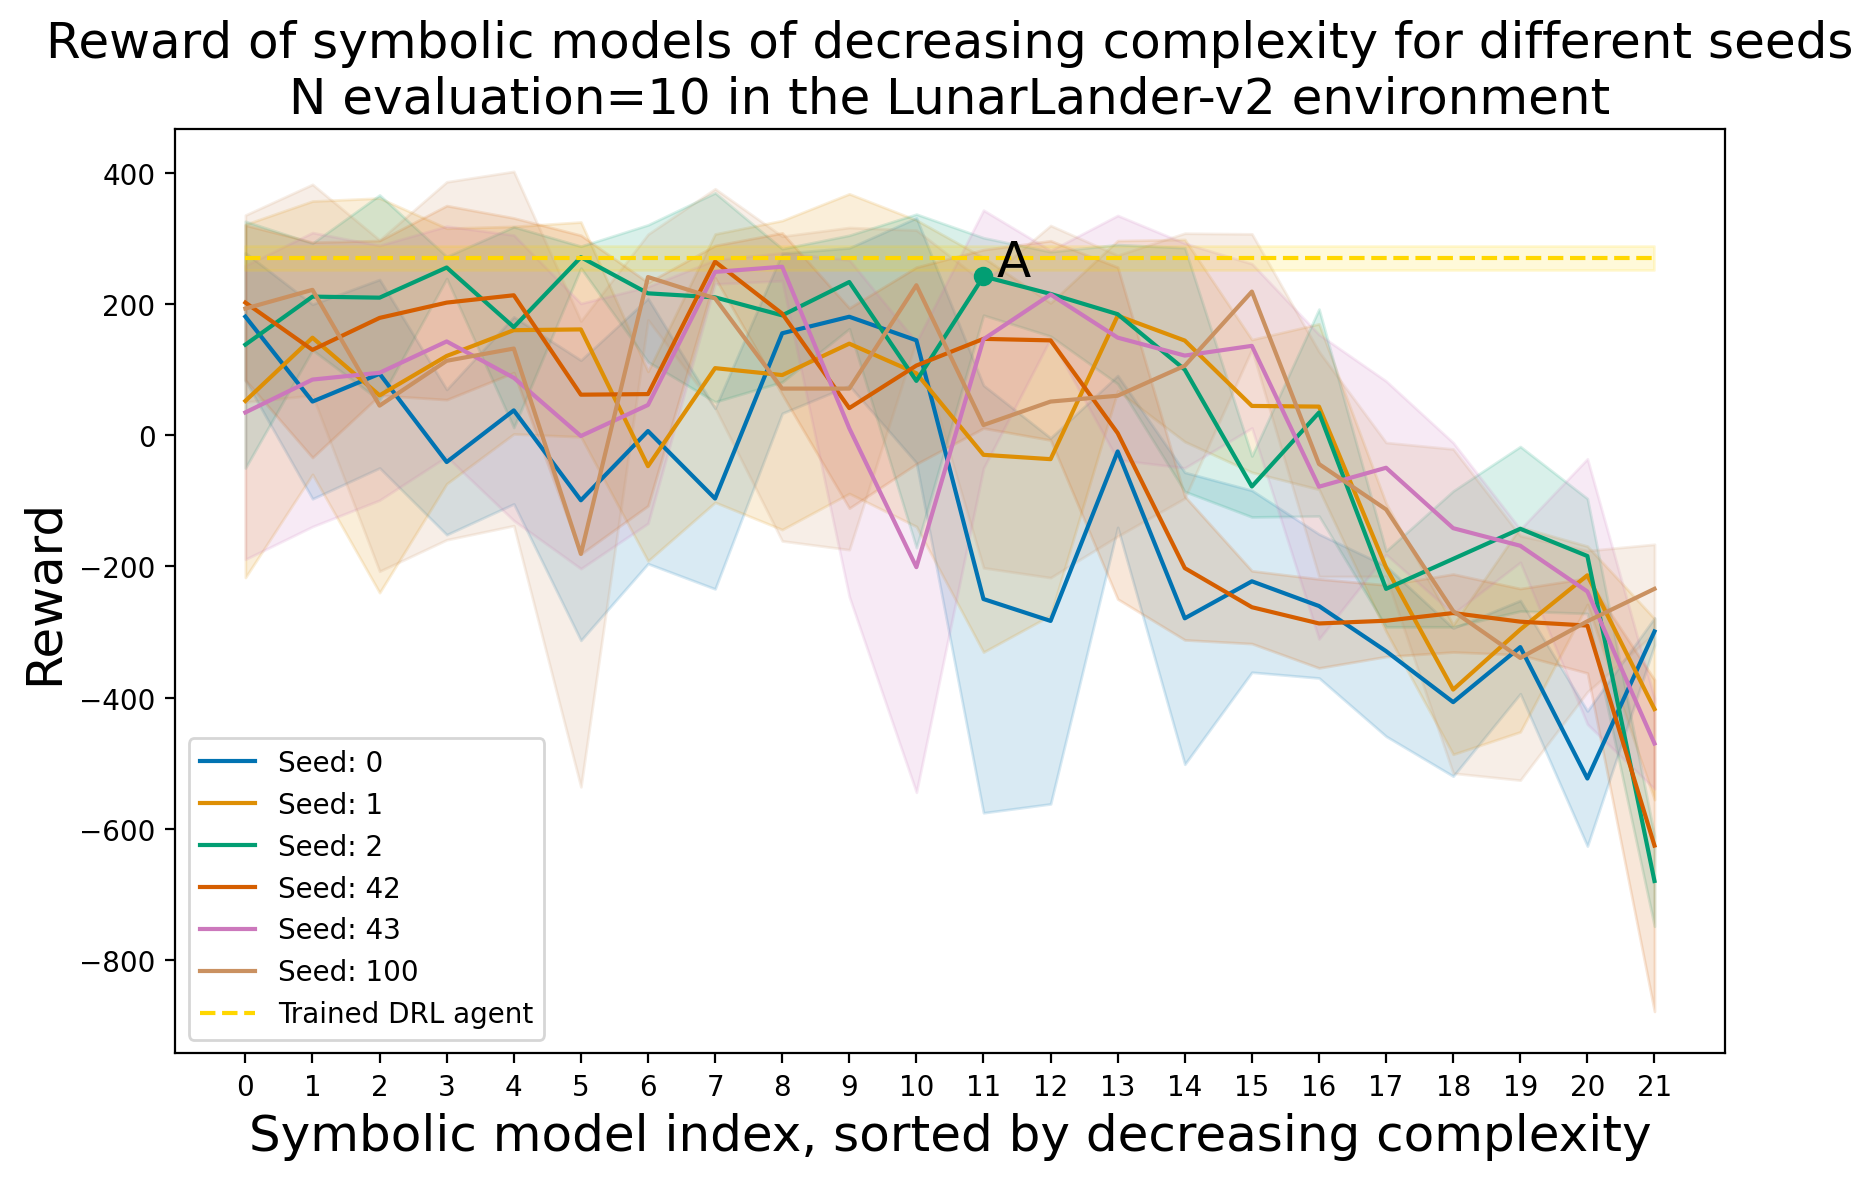

Point: Seed 2, Position 11
Action 0: abs(tanh(((-0.39965034 - tanh(x3)) / (3.039439 - x1)) / x3))
Complexity: 12
Action 1: atanh_clip(relu(0.15576722 - ((x7 + x5) + ((x4 - x2) * 1.2659489))))
Complexity: 13
Action 2: (tanh(relu(((-10.091324 * x3) - 2.1895328) - x1)) - x4) - x5
Complexity: 13
Action 3: relu(x4 + (sqrt(relu(x5) - -0.0095013315) - ((x2 + x0) + x7)))
Complexity: 14


In [3]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from google.colab import drive
from pysr import PySRRegressor
from rliable import library as rly
from rliable import metrics, plot_utils
import seaborn as sns

# Mount Google Drive to store and retrieve results
use_drive = True
directory = "ATRL/"
if use_drive:
    drive.mount('/content/drive', force_remount=True)
    storage_path = '/content/drive/MyDrive/' + directory
else:
    storage_path = directory

# List all files in the directory
files = [f for f in os.listdir(storage_path) if os.path.isfile(os.path.join(storage_path, f))]
print("Available files:", files)

def load_experiment_data(designation):
    """
    Load symbolic models and episode rewards from files.

    Parameters:
        designation (str): Identifier for the specific experiment.

    Returns:
        tuple: symbolic models and episode rewards.
    """
    model_file = os.path.join(storage_path, f'pysr_models_{designation}.pkl')
    rewards_file = os.path.join(storage_path, f'episode_rewards_{designation}.pkl')

    # Load symbolic models
    with open(model_file, 'rb') as f:
        symbolic_models = pickle.load(f)

    # Load episode rewards
    with open(rewards_file, 'rb') as f:
        all_rewards = pickle.load(f)

    return symbolic_models, all_rewards

# Define parameters for seeds and randomness
initial_random = 1000
seeds_ = [0, 1, 2, 42, 43, 100]
min_length_ = -1
results_for_seeds_ = []

# Load and process experimental data for each seed
for seed in seeds_:
    designation = f"r{initial_random}_s{seed}"
    symbolic_models, all_rewards = load_experiment_data(designation)

    # Track the minimum length of reward sequences
    if min_length_ == -1 or min_length_ >= len(all_rewards):
        min_length_ = len(all_rewards)

    # Store results (mean and std) for each seed
    results = [[np.mean(rewards), np.std(rewards), rewards] for rewards in all_rewards]
    results_for_seeds_.append([results, symbolic_models])

# Plotting the results
k_indices = np.arange(len(results))
plt.figure(figsize=(10, 6), dpi=200)

# Define color palette for better visualization
color_palette = sns.color_palette('colorblind')

# Plot results for each seed
for seed_index, seed in enumerate(seeds_):
    results = results_for_seeds_[seed_index][0]
    mean_rewards = [result[0] for result in results]
    std_rewards = [result[1] for result in results]

    plt.plot(k_indices[:min_length_], mean_rewards[:min_length_],
             label=f"Seed: {seed}", color=color_palette[seed_index], alpha=1.0)
    plt.fill_between(k_indices[:min_length_],
                     np.array(mean_rewards)[:min_length_] - np.array(std_rewards)[:min_length_],
                     np.array(mean_rewards)[:min_length_] + np.array(std_rewards)[:min_length_],
                     color=color_palette[seed_index], alpha=0.15)

# Add reference performance (Trained DRL agent)
(ref_mean, ref_std) = 270.60, 18.20
plt.plot(k_indices[:min_length_], [ref_mean] * min_length_, '--', label="Trained DRL agent", color="gold", alpha=1.0)
plt.fill_between(k_indices[:min_length_],
                 [ref_mean - ref_std] * min_length_,
                 [ref_mean + ref_std] * min_length_, color="gold", alpha=0.15)

# Highlight specific data points for deeper analysis
highlighted_point = (2, 11)
plt.plot(highlighted_point[1], results_for_seeds_[highlighted_point[0]][0][highlighted_point[1]][0], 'ro', color=color_palette[highlighted_point[0]])
plt.text(highlighted_point[1] + 0.2, results_for_seeds_[highlighted_point[0]][0][highlighted_point[1]][0] - 0.2, "A", size=18)

# Add labels and titles
plt.xlabel("Symbolic model index, sorted by decreasing complexity", fontsize=18)
plt.ylabel("Reward", fontsize=18)
plt.title("Reward of symbolic models of decreasing complexity for different seeds\nN evaluation=10 in the LunarLander-v2 environment", fontsize=18)
plt.legend()
plt.xticks(k_indices[:min_length_])
plt.show()

# Retrieve symbolic equations for selected points A, B, C
points = [(2, 11)]  # , (5, 15), (2, 5)]
for seed_index, pos in points:
    symbolic_models = results_for_seeds_[seed_index][1]
    print(f"Point: Seed {seed_index}, Position {pos}")

    for action_index in range(4):  # Assuming four actions
        equation = symbolic_models[action_index].equations_['equation'].tolist()[-(pos+1)]
        complexity = symbolic_models[action_index].equations_['complexity'].tolist()[-(pos+1)]
        print(f"Action {action_index}: {equation}")
        print(f"Complexity: {complexity}")
    print("")  # Blank line for readability